In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import SamplerV2


In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend = AerSimulator()
backend

AerSimulator('aer_simulator')

In [3]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

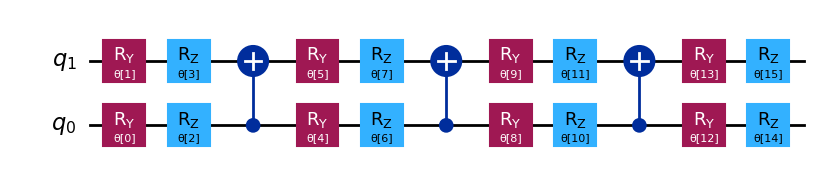

In [4]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [5]:
num_params = ansatz.num_parameters
num_params

16

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

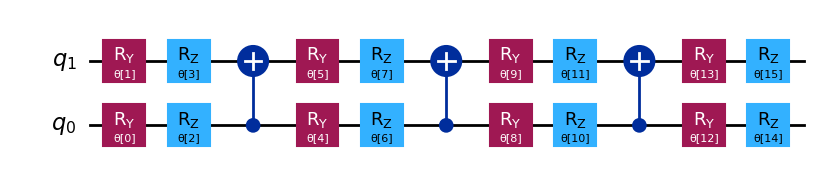

In [7]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [8]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

#### Cost Function

In [9]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    # pub = (ansatz, [hamiltonian], [params])
    # result = estimator.run(pubs=[pub]).result()
    # energy = result[0].data.evs[0]


    # hamiltonian = SparsePauliOp.from_list(
    # [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)])
    shots = 10000
    energy = 0

    ansatz_1 = ansatz.copy()
    ansatz_1.sdg(0)
    ansatz_1.h(0)
    ansatz_1.cx(0,1)
    cr_1 = ClassicalRegister(1, name='my_c_1')
    ansatz_1.add_register(cr_1)
    ansatz_1.measure(1, cbit=cr_1)
    sampler = SamplerV2(backend=AerSimulator())
    job = sampler.run([(ansatz_1, [params], shots)])
    counts = job.result()[0].data.my_c_1.get_counts()
    total = sum(counts.values())
    probabilities = { state: count/total for state, count in counts.items() }
    probabilities['0'] = probabilities.get('0', 0.0)
    probabilities['1'] = probabilities.get('1', 0.0)
    exp_vals = (probabilities['0'])**2 - (probabilities['1'])**2
    # energy += exp_vals*0.3980
    energy += exp_vals
    

    ansatz_2 = ansatz.copy()
    ansatz_2.cx(0,1)
    cr_2 = ClassicalRegister(1, name='my_c_2')
    ansatz_2.add_register(cr_2)
    ansatz_2.measure(1, cbit=cr_2)
    sampler = SamplerV2(backend=AerSimulator())
    job = sampler.run([(ansatz_2, [params], shots)])
    counts = job.result()[0].data.my_c_2.get_counts()
    total = sum(counts.values())
    probabilities = { state: count/total for state, count in counts.items() }
    probabilities['0'] = probabilities.get('0', 0.0)
    probabilities['1'] = probabilities.get('1', 0.0)
    exp_vals = (probabilities['0'])**2 - (probabilities['1'])**2
    # energy += exp_vals*(-0.3980-0.0113)
    energy += exp_vals


    ansatz_3 = ansatz.copy()
    ansatz_3.h([0,1])
    ansatz_3.cx(0,1)
    cr_3 = ClassicalRegister(1, name='my_c_3')
    ansatz_3.add_register(cr_3)
    ansatz_3.measure(1, cbit=cr_3)
    sampler = SamplerV2(backend=AerSimulator())
    job = sampler.run([(ansatz_3, [params], shots)])
    counts = job.result()[0].data.my_c_3.get_counts()
    total = sum(counts.values())
    probabilities = { state: count/total for state, count in counts.items() }
    probabilities['0'] = probabilities.get('0', 0.0)
    probabilities['1'] = probabilities.get('1', 0.0)
    exp_vals = (probabilities['0'])**2 - (probabilities['1'])**2
    # energy += exp_vals*(0.1810)
    energy += exp_vals

    

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [10]:
np.random.seed(42)
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.35330497, 5.97351416, 4.59925358, 3.76148219, 0.98029403,
       0.98014248, 0.3649501 , 5.44234523, 3.77691701, 4.44895122,
       0.12933619, 6.09412333, 5.23039137, 1.33416598, 1.14243996,
       1.15236452])

In [11]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

/home/azhar04/anaconda3/envs/qiskit-1-2/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Iters. done: 1 [Current cost: 0.7121999999999998]
Iters. done: 2 [Current cost: -0.11800000000000005]
Iters. done: 3 [Current cost: -0.6176]
Iters. done: 4 [Current cost: -0.7128000000000001]
Iters. done: 5 [Current cost: -1.0352000000000001]
Iters. done: 6 [Current cost: -0.20559999999999995]
Iters. done: 7 [Current cost: -1.0984]
Iters. done: 8 [Current cost: -0.9300000000000002]
Iters. done: 9 [Current cost: -0.05700000000000016]
Iters. done: 10 [Current cost: -0.7808000000000002]
Iters. done: 11 [Current cost: -0.6562]
Iters. done: 12 [Current cost: -0.6006]
Iters. done: 13 [Current cost: -1.1152]
Iters. done: 14 [Current cost: -1.8486]
Iters. done: 15 [Current cost: -0.9339999999999999]
Iters. done: 16 [Current cost: -1.3017999999999998]
Iters. done: 17 [Current cost: -1.7058]
Iters. done: 18 [Current cost: -0.9736]
Iters. done: 19 [Current cost: -1.7362]
Iters. done: 20 [Current cost: -1.3181999999999998]
Iters. done: 21 [Current cost: -1.8672]
Iters. done: 22 [Current cost: -1.7

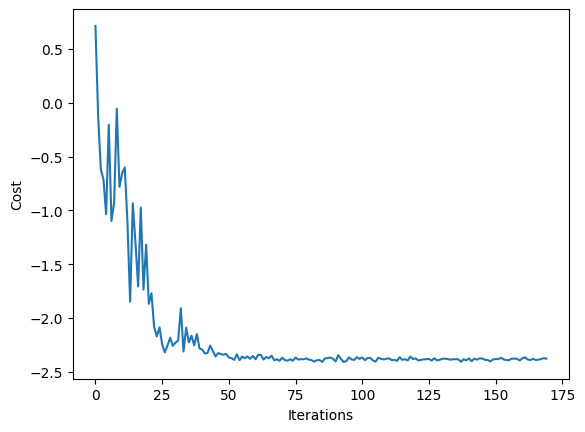

In [12]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()